<p> Code found <a href="https://www.youtube.com/watch?v=M2PqI2JD2jo&feature=youtu.be">on the internet</a>.</p>

In [1]:
from numpy import *
from numpy.linalg import *
import matplotlib.pyplot as plt
from matplotlib import cm
from numba import jit
import time as time

In [2]:
from mpl_toolkits import axes_grid1

#https://stackoverflow.com/questions/18195758/set-matplotlib-colorbar-size-to-match-graph
def add_colorbar(im, aspect=20, pad_fraction=0.5, **kwargs):
    """Add a vertical color bar to an image plot."""
    divider = axes_grid1.make_axes_locatable(im.axes)
    width = axes_grid1.axes_size.AxesY(im.axes, aspect=1./aspect)
    pad = axes_grid1.axes_size.Fraction(pad_fraction, width)
    current_ax = plt.gca()
    cax = divider.append_axes("right", size=width, pad=pad)
    plt.sca(current_ax)
    return im.axes.figure.colorbar(im, cax=cax, **kwargs)

In [3]:
maxIter = 200000 # Total number of time iterations.
Re      = 25.0  # Reynolds number.

finegrain = 4.00

nx = int(1024*finegrain)
ny = int(1024/2*finegrain)
ly=ny-1.0
q = 9 # Lattice dimensions and populations.


cx = nx/4
cy=ny/2
r=7*ny/9/2          # Coordinates of the cylinder.

uLB     = 0.04                       # Velocity in lattice units.
nulb    = uLB*r/Re; omega = 1.0 / (3.*nulb+0.5); # Relaxation parameter.


In [4]:
c = array([(x,y) for x in [0,-1,1] for y in [0,-1,1]]) # Lattice velocities.
t = 1./36. * ones(q)                                   # Lattice weights.
t[asarray([norm(ci)<1.1 for ci in c])] = 1./9.; t[0] = 4./9.
noslip = [c.tolist().index((-c[i]).tolist()) for i in range(q)] 
i1 = arange(q)[asarray([ci[0]<0  for ci in c])] # Unknown on right wall.
i2 = arange(q)[asarray([ci[0]==0 for ci in c])] # Vertical middle.
i3 = arange(q)[asarray([ci[0]>0  for ci in c])] # Unknown on left wall.


In [5]:
sumpop = lambda fin: sum(fin,axis=0) # Helper function for density computation.
@jit(parallel=True)
def equilibrium(rho,u):              # Equilibrium distribution function.
    cu   = 3.0 * dot(c,u.transpose(1,0,2))
    usqr = 3./2.*(u[0]**2+u[1]**2)
    feq = zeros((q,nx,ny))
    for i in range(q): feq[i,:,:] = rho*t[i]*(1.+cu[i]+0.5*cu[i]**2-usqr)
    return feq

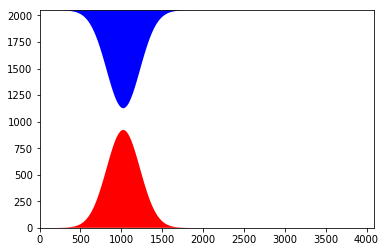

In [6]:

gaussian = lambda x, amp, mu, sigma:amp* ny * exp( -(x-mu)**2 / (2*sigma**2))

x = linspace(0, nx, 1000)
y = gaussian(x, 0.45, nx/4, nx/20)
y2 = ny-gaussian(x, 0.45, nx/4, nx/20)

plt.fill(x, y, 'r-', x, y2, 'b-')
plt.xlim(0, nx)
plt.ylim(0, ny)
plt.show()
plt.close()

In [7]:
obstacle_one = fromfunction(lambda x,y: gaussian(x, 0.45, nx/4, nx/20) > y, (nx,ny))
obstacle_two = fromfunction(lambda x,y: ny-gaussian(x, 0.45, nx/4, nx/20) < y, (nx,ny))

obstacle = obstacle_one + obstacle_two

vel = fromfunction(lambda d,x,y: (1-d)*uLB*(1.0+1e-4*sin(y/ly*2*pi)),(2,nx,ny))
feq = equilibrium(1.0,vel)
fin = feq.copy()


In [ ]:
start_time = time.time ()
report_time = start_time

for j in range(maxIter): 
    fin[i1,-1,:] = fin[i1,-2,:] # Right wall: outflow condition.
    rho = sumpop(fin)           # Calculate macroscopic density and velocity.
    u = dot(c.transpose(), fin.transpose((1,0,2)))/rho

    u[:,0,:] =vel[:,0,:] # Left wall: compute density from known populations.
    rho[0,:] = 1./(1.-u[0,0,:]) * (sumpop(fin[i2,0,:])+2.*sumpop(fin[i1,0,:]))

    feq = equilibrium(rho,u) # Left wall: Zou/He boundary condition.
    fin[i3,0,:] = fin[i1,0,:] + feq[i3,0,:] - fin[i1,0,:]
    fout = fin - omega * (fin - feq)  # Collision step.
    for i in range(q):
        fout[i,obstacle] = fin[noslip[i],obstacle]
    for i in range(q): # Streaming step.
        fin[i,:,:] = roll(roll(fout[i,:,:],c[i,0],axis=0),c[i,1],axis=1)
 
    elapsed_time = time.time() - report_time
    
    if elapsed_time > 10:
        print ("Iteration %d, time spent %.3f (total %.3f)" % (j, elapsed_time, time.time() - start_time))
        report_time = time.time()
        
    if (j%100==0): # Visualization
        print ("Iteration %d, time spent %.3f" % (j, time.time() - start_time))
        plt.clf()
        plt.figure(dpi=1200)
        im = plt.imshow(sqrt(u[0]**2+u[1]**2).transpose(),cmap=cm.winter)
        plt.title("Iteration %d, Re=%d" % (j, Re))
        add_colorbar(im)
        plt.savefig("palabos/constriction_two_sides_finegrain%diteration%dre%d.png" % (finegrain*100, j, Re))
        plt.close()  


Iteration 0, time spent 4.182
Iteration 1, time spent 10.982 (total 10.982)
Iteration 4, time spent 11.431 (total 22.414)
Iteration 7, time spent 11.441 (total 33.855)
Iteration 10, time spent 11.433 (total 45.289)
Iteration 13, time spent 11.358 (total 56.648)
Iteration 16, time spent 11.476 (total 68.123)
Iteration 19, time spent 11.389 (total 79.512)
Iteration 22, time spent 11.365 (total 90.878)
Iteration 25, time spent 11.421 (total 102.299)
Iteration 28, time spent 11.424 (total 113.723)
Iteration 31, time spent 11.417 (total 125.141)
Iteration 34, time spent 11.460 (total 136.601)
Iteration 37, time spent 11.393 (total 147.996)
Iteration 40, time spent 11.379 (total 159.375)
Iteration 43, time spent 11.422 (total 170.797)
Iteration 46, time spent 11.369 (total 182.166)
Iteration 49, time spent 11.417 (total 193.584)
Iteration 52, time spent 11.390 (total 204.974)
Iteration 55, time spent 11.398 (total 216.372)
Iteration 58, time spent 11.398 (total 227.771)
Iteration 61, time sp

Iteration 491, time spent 11.402 (total 1884.058)
Iteration 494, time spent 11.404 (total 1895.462)
Iteration 497, time spent 11.383 (total 1906.845)
Iteration 500, time spent 11.414 (total 1918.260)
Iteration 500, time spent 1918.260
Iteration 502, time spent 10.665 (total 1928.925)
Iteration 505, time spent 11.434 (total 1940.359)
Iteration 508, time spent 11.366 (total 1951.726)
Iteration 511, time spent 11.340 (total 1963.066)
Iteration 514, time spent 11.352 (total 1974.418)
Iteration 517, time spent 11.353 (total 1985.771)
Iteration 520, time spent 11.379 (total 1997.150)
Iteration 523, time spent 11.354 (total 2008.505)
Iteration 526, time spent 11.397 (total 2019.902)
Iteration 529, time spent 11.368 (total 2031.270)
Iteration 532, time spent 11.376 (total 2042.646)
Iteration 535, time spent 11.343 (total 2053.990)
Iteration 538, time spent 11.372 (total 2065.362)
Iteration 541, time spent 11.359 (total 2076.721)
Iteration 544, time spent 11.371 (total 2088.092)
Iteration 547, 

Iteration 971, time spent 11.402 (total 3718.082)
Iteration 974, time spent 11.423 (total 3729.505)
Iteration 977, time spent 11.394 (total 3740.900)
Iteration 980, time spent 11.344 (total 3752.244)
Iteration 983, time spent 11.409 (total 3763.653)
Iteration 986, time spent 11.393 (total 3775.046)
Iteration 989, time spent 11.358 (total 3786.405)
Iteration 992, time spent 11.353 (total 3797.758)
Iteration 995, time spent 11.386 (total 3809.144)
Iteration 998, time spent 11.322 (total 3820.466)
Iteration 1000, time spent 3828.024
Iteration 1001, time spent 14.406 (total 3834.872)
Iteration 1004, time spent 11.447 (total 3846.320)
Iteration 1007, time spent 11.388 (total 3857.708)
Iteration 1010, time spent 11.365 (total 3869.073)
Iteration 1013, time spent 11.396 (total 3880.470)
Iteration 1016, time spent 11.415 (total 3891.885)
Iteration 1019, time spent 11.429 (total 3903.315)
Iteration 1022, time spent 11.390 (total 3914.707)
Iteration 1025, time spent 11.416 (total 3926.123)
Itera

Iteration 1443, time spent 11.398 (total 5531.058)
Iteration 1446, time spent 11.371 (total 5542.429)
Iteration 1449, time spent 11.405 (total 5553.834)
Iteration 1452, time spent 11.409 (total 5565.244)
Iteration 1455, time spent 11.413 (total 5576.657)
Iteration 1458, time spent 11.405 (total 5588.062)
Iteration 1461, time spent 11.363 (total 5599.425)
Iteration 1464, time spent 11.398 (total 5610.824)
Iteration 1467, time spent 11.406 (total 5622.230)
Iteration 1470, time spent 11.446 (total 5633.676)
Iteration 1473, time spent 11.449 (total 5645.125)
Iteration 1476, time spent 11.390 (total 5656.516)
Iteration 1479, time spent 11.400 (total 5667.916)
Iteration 1482, time spent 11.393 (total 5679.310)
Iteration 1485, time spent 11.499 (total 5690.808)
Iteration 1488, time spent 11.439 (total 5702.247)
Iteration 1491, time spent 11.394 (total 5713.641)
Iteration 1494, time spent 11.399 (total 5725.040)
Iteration 1497, time spent 11.374 (total 5736.414)
Iteration 1500, time spent 11.4

Iteration 1914, time spent 11.301 (total 7333.547)
Iteration 1917, time spent 11.384 (total 7344.931)
Iteration 1920, time spent 11.340 (total 7356.272)
Iteration 1923, time spent 11.418 (total 7367.690)
Iteration 1926, time spent 11.373 (total 7379.063)
Iteration 1929, time spent 11.379 (total 7390.443)
Iteration 1932, time spent 11.338 (total 7401.781)
Iteration 1935, time spent 11.379 (total 7413.160)
Iteration 1938, time spent 11.385 (total 7424.545)
Iteration 1941, time spent 11.366 (total 7435.912)
Iteration 1944, time spent 11.348 (total 7447.260)
Iteration 1947, time spent 11.395 (total 7458.656)
Iteration 1950, time spent 11.412 (total 7470.068)
Iteration 1953, time spent 11.390 (total 7481.458)
Iteration 1956, time spent 11.358 (total 7492.817)
Iteration 1959, time spent 11.326 (total 7504.143)
Iteration 1962, time spent 11.348 (total 7515.491)
Iteration 1965, time spent 11.377 (total 7526.868)
Iteration 1968, time spent 11.364 (total 7538.232)
Iteration 1971, time spent 11.4

Iteration 2386, time spent 11.515 (total 9133.848)
Iteration 2389, time spent 11.398 (total 9145.246)
Iteration 2392, time spent 11.311 (total 9156.557)
Iteration 2395, time spent 11.357 (total 9167.915)
Iteration 2398, time spent 11.343 (total 9179.258)
Iteration 2400, time spent 9186.856
Iteration 2401, time spent 14.409 (total 9193.668)
Iteration 2404, time spent 11.335 (total 9205.003)
Iteration 2407, time spent 11.312 (total 9216.315)
Iteration 2410, time spent 11.341 (total 9227.657)
Iteration 2413, time spent 11.373 (total 9239.030)
Iteration 2416, time spent 11.348 (total 9250.378)
Iteration 2419, time spent 11.366 (total 9261.744)
Iteration 2422, time spent 11.309 (total 9273.054)
Iteration 2425, time spent 11.355 (total 9284.409)
Iteration 2428, time spent 11.467 (total 9295.877)
Iteration 2431, time spent 11.381 (total 9307.258)
Iteration 2434, time spent 11.326 (total 9318.584)
Iteration 2437, time spent 11.350 (total 9329.934)
Iteration 2440, time spent 11.363 (total 9341.

Iteration 2852, time spent 11.324 (total 10911.283)
Iteration 2855, time spent 11.334 (total 10922.617)
Iteration 2858, time spent 11.308 (total 10933.926)
Iteration 2861, time spent 11.335 (total 10945.261)
Iteration 2864, time spent 11.381 (total 10956.642)
Iteration 2867, time spent 11.291 (total 10967.933)
Iteration 2870, time spent 11.314 (total 10979.247)
Iteration 2873, time spent 11.300 (total 10990.547)
Iteration 2876, time spent 11.357 (total 11001.904)
Iteration 2879, time spent 11.332 (total 11013.236)
Iteration 2882, time spent 11.341 (total 11024.578)
Iteration 2885, time spent 11.338 (total 11035.916)
Iteration 2888, time spent 11.353 (total 11047.269)
Iteration 2891, time spent 11.354 (total 11058.623)
Iteration 2894, time spent 11.350 (total 11069.973)
Iteration 2897, time spent 11.296 (total 11081.269)
Iteration 2900, time spent 11.426 (total 11092.696)
Iteration 2900, time spent 11092.697
Iteration 2902, time spent 10.505 (total 11103.202)
Iteration 2905, time spent 

Iteration 3311, time spent 11.313 (total 12660.820)
Iteration 3314, time spent 11.319 (total 12672.139)
Iteration 3317, time spent 11.317 (total 12683.458)
Iteration 3320, time spent 11.323 (total 12694.781)
Iteration 3323, time spent 11.300 (total 12706.081)
Iteration 3326, time spent 11.308 (total 12717.389)
Iteration 3329, time spent 11.278 (total 12728.667)
Iteration 3332, time spent 11.333 (total 12740.000)
Iteration 3335, time spent 11.311 (total 12751.311)
Iteration 3338, time spent 11.331 (total 12762.642)
Iteration 3341, time spent 11.344 (total 12773.986)
Iteration 3344, time spent 11.319 (total 12785.305)
Iteration 3347, time spent 11.353 (total 12796.659)
Iteration 3350, time spent 11.299 (total 12807.958)
Iteration 3353, time spent 11.265 (total 12819.223)
Iteration 3356, time spent 11.354 (total 12830.577)
Iteration 3359, time spent 11.352 (total 12841.929)
Iteration 3362, time spent 11.325 (total 12853.254)
Iteration 3365, time spent 11.300 (total 12864.554)
Iteration 33

Iteration 3774, time spent 11.361 (total 14422.139)
Iteration 3777, time spent 11.318 (total 14433.457)
Iteration 3780, time spent 11.352 (total 14444.810)
Iteration 3783, time spent 11.327 (total 14456.138)
Iteration 3786, time spent 11.329 (total 14467.467)
Iteration 3789, time spent 11.286 (total 14478.753)
Iteration 3792, time spent 11.280 (total 14490.033)
Iteration 3795, time spent 11.352 (total 14501.385)
Iteration 3798, time spent 11.332 (total 14512.718)
Iteration 3800, time spent 14520.260
Iteration 3801, time spent 14.316 (total 14527.034)
Iteration 3804, time spent 11.320 (total 14538.354)
Iteration 3807, time spent 11.277 (total 14549.631)
Iteration 3810, time spent 11.302 (total 14560.933)
Iteration 3813, time spent 11.311 (total 14572.244)
Iteration 3816, time spent 11.301 (total 14583.545)
Iteration 3819, time spent 11.262 (total 14594.807)
Iteration 3822, time spent 11.282 (total 14606.089)
Iteration 3825, time spent 11.315 (total 14617.404)
Iteration 3828, time spent 

Iteration 4234, time spent 11.343 (total 16173.610)
Iteration 4237, time spent 11.369 (total 16184.980)
Iteration 4240, time spent 11.285 (total 16196.265)
Iteration 4243, time spent 11.330 (total 16207.595)
Iteration 4246, time spent 11.315 (total 16218.910)
Iteration 4249, time spent 11.312 (total 16230.222)
Iteration 4252, time spent 11.290 (total 16241.512)
Iteration 4255, time spent 11.336 (total 16252.848)
Iteration 4258, time spent 11.347 (total 16264.195)
Iteration 4261, time spent 11.340 (total 16275.536)
Iteration 4264, time spent 11.325 (total 16286.861)
Iteration 4267, time spent 11.269 (total 16298.130)
Iteration 4270, time spent 11.274 (total 16309.404)
Iteration 4273, time spent 11.313 (total 16320.717)
Iteration 4276, time spent 11.350 (total 16332.068)
Iteration 4279, time spent 11.324 (total 16343.392)
Iteration 4282, time spent 11.381 (total 16354.774)
Iteration 4285, time spent 11.324 (total 16366.098)
Iteration 4288, time spent 11.354 (total 16377.452)
Iteration 42

Iteration 4697, time spent 11.335 (total 17933.254)
Iteration 4700, time spent 11.298 (total 17944.552)
Iteration 4700, time spent 17944.552
Iteration 4702, time spent 10.590 (total 17955.142)
Iteration 4705, time spent 11.340 (total 17966.483)
Iteration 4708, time spent 11.324 (total 17977.807)
Iteration 4711, time spent 11.320 (total 17989.128)
Iteration 4714, time spent 11.294 (total 18000.422)
Iteration 4717, time spent 11.290 (total 18011.712)
Iteration 4720, time spent 11.323 (total 18023.035)
Iteration 4723, time spent 11.297 (total 18034.332)
Iteration 4726, time spent 11.319 (total 18045.651)
Iteration 4729, time spent 11.341 (total 18056.992)
Iteration 4732, time spent 11.361 (total 18068.354)
Iteration 4735, time spent 11.338 (total 18079.692)
Iteration 4738, time spent 11.340 (total 18091.032)
Iteration 4741, time spent 11.391 (total 18102.423)
Iteration 4744, time spent 11.339 (total 18113.762)
Iteration 4747, time spent 11.344 (total 18125.106)
Iteration 4750, time spent 

Iteration 5156, time spent 11.353 (total 19681.122)
Iteration 5159, time spent 11.301 (total 19692.423)
Iteration 5162, time spent 11.283 (total 19703.706)
Iteration 5165, time spent 11.330 (total 19715.036)
Iteration 5168, time spent 11.372 (total 19726.408)
Iteration 5171, time spent 11.325 (total 19737.735)
Iteration 5174, time spent 11.294 (total 19749.029)
Iteration 5177, time spent 11.321 (total 19760.350)
Iteration 5180, time spent 11.313 (total 19771.663)
Iteration 5183, time spent 11.330 (total 19782.993)
Iteration 5186, time spent 11.337 (total 19794.330)
Iteration 5189, time spent 11.352 (total 19805.682)
Iteration 5192, time spent 11.325 (total 19817.007)
Iteration 5195, time spent 11.277 (total 19828.284)
Iteration 5198, time spent 11.328 (total 19839.612)
Iteration 5200, time spent 19847.127
Iteration 5201, time spent 14.331 (total 19853.944)
Iteration 5204, time spent 11.310 (total 19865.254)
Iteration 5207, time spent 11.342 (total 19876.596)
Iteration 5210, time spent 

Iteration 5616, time spent 11.362 (total 21434.195)
Iteration 5619, time spent 11.364 (total 21445.559)
Iteration 5622, time spent 11.517 (total 21457.076)
Iteration 5625, time spent 11.576 (total 21468.653)
Iteration 5628, time spent 11.487 (total 21480.140)
Iteration 5631, time spent 11.383 (total 21491.523)
Iteration 5634, time spent 11.475 (total 21502.998)
Iteration 5637, time spent 11.410 (total 21514.408)
Iteration 5640, time spent 11.518 (total 21525.926)
Iteration 5643, time spent 11.408 (total 21537.334)
Iteration 5646, time spent 11.393 (total 21548.728)
Iteration 5649, time spent 11.424 (total 21560.152)
Iteration 5652, time spent 11.394 (total 21571.546)
Iteration 5655, time spent 11.359 (total 21582.905)
Iteration 5658, time spent 11.379 (total 21594.285)
Iteration 5661, time spent 11.357 (total 21605.642)
Iteration 5664, time spent 11.391 (total 21617.033)
Iteration 5667, time spent 11.331 (total 21628.364)
Iteration 5670, time spent 11.339 (total 21639.703)
Iteration 56

Iteration 6079, time spent 11.350 (total 23197.127)
Iteration 6082, time spent 11.340 (total 23208.467)
Iteration 6085, time spent 11.316 (total 23219.783)
Iteration 6088, time spent 11.321 (total 23231.104)
Iteration 6091, time spent 11.318 (total 23242.423)
Iteration 6094, time spent 11.328 (total 23253.751)
Iteration 6097, time spent 11.328 (total 23265.079)
Iteration 6100, time spent 11.299 (total 23276.378)
Iteration 6100, time spent 23276.378
Iteration 6102, time spent 10.538 (total 23286.916)
Iteration 6105, time spent 11.326 (total 23298.243)
Iteration 6108, time spent 11.403 (total 23309.646)
Iteration 6111, time spent 11.393 (total 23321.039)
Iteration 6114, time spent 11.343 (total 23332.382)
Iteration 6117, time spent 11.306 (total 23343.688)
Iteration 6120, time spent 11.298 (total 23354.986)
Iteration 6123, time spent 11.315 (total 23366.302)
Iteration 6126, time spent 11.306 (total 23377.608)
Iteration 6129, time spent 11.305 (total 23388.913)
Iteration 6132, time spent 

Iteration 6538, time spent 11.371 (total 24948.846)
Iteration 6541, time spent 11.368 (total 24960.214)
Iteration 6544, time spent 11.353 (total 24971.567)
Iteration 6547, time spent 11.395 (total 24982.962)
Iteration 6550, time spent 11.287 (total 24994.249)
